In [1]:
import numpy as np

side = 10
scatter_radius = 4
particle_radius = 2
speed = 1.0
num_walls = 5
hole = 3
max_steps = 1000

abs_tol = 1e-5
rel_tol = 0.01
rnd = np.random.RandomState(seed=42)

x_range = side - particle_radius
y_range = side - particle_radius
scatter_range = scatter_radius + particle_radius
hole_range = hole - particle_radius
bdy_length = 2*2*x_range + 2*2*y_range + 2*np.pi*scatter_range
hb_ratio = 2 * hole_range / bdy_length

params = np.array([side, scatter_radius, particle_radius, speed, x_range-scatter_range, y_range-scatter_range])
if np.any(params <= abs_tol):
    print(params)
    raise Exception('Parameters must all be positive')
if hole <= particle_radius:
    print('Hole is too small for particle to escape')
    
normals = [np.array([1,0])
           ,np.array([-1,0])
           ,np.array([0,1])
           ,np.array([0,-1])
          ]

def check_position(pos):
    ok = True
    if abs(pos[0]) > (1+rel_tol) * x_range:
        ok = False
    if abs(pos[1]) > (1+rel_tol) * y_range:
        ok = False
    if pos.dot(pos) < (1-rel_tol) * scatter_range**2:
        ok = False
    return ok

def error_message():
    raise Exception('Particle escaped at step {} \n pos = {} \n vel = {}'.format(step, pos, vel))

def solve_quadratic(a, b, c):
    d = b**2 - 4*a*c
    if d > abs_tol:
        e = np.sqrt(d)
        small = (-b - e) / (2*a)
        big   = (-b + e) / (2*a)
        if b > 0:
            small, big = big, small
    else:
        small, big = np.inf, np.inf
    return small, big

def run_trial(x=None, y=None, speed=1.0, theta=None):
    rand_x = x is None
    rand_y = y is None
    if rand_x or rand_y:
        r = 0
    else:
        r = np.sqrt(x**2+y**2)
    while r < (1+rel_tol) * scatter_range:
        if rand_x is True:
            x = rnd.uniform(low=-(1-rel_tol)*x_range, high=(1-rel_tol)*x_range)
        if rand_y is True:
            y = rnd.uniform(low=-(1-rel_tol)*y_range, high=(1-rel_tol)*y_range)
    pos = np.array([x,y])
    if theta is None:
        theta = rnd.uniform(low=0, high=2*np.pi)
    vel = speed * np.array([np.cos(theta), np.sin(theta)])
    
    t = 0
    t_hist = [t]
    pos_hist = [pos.copy()]
    vel_hist = [vel.copy()]

    dts = np.zeros(num_walls)
    prior_collision = num_walls
    for step in range(max_steps):
        if check_position(pos) == False:
            error_message()
        dts[:] = np.inf

        if abs(vel[0]) > abs_tol:
            dts[0] = (-x_range - pos[0]) / vel[0]
            dts[1] = ( x_range - pos[0]) / vel[0]

        if abs(vel[1]) > abs_tol:
            dts[2] = (-y_range - pos[1]) / vel[1]
            dts[3] = ( y_range - pos[1]) / vel[1]
        if prior_collision in range(0,4):
            dts[prior_collision] = np.inf

        a = vel.dot(vel)
        if a  > abs_tol:
            b = 2 * pos.dot(vel)
            c = pos.dot(pos) - scatter_range**2
            small, big = solve_quadratic(a, b, c)
            if prior_collision == 4:
                dts[4] = big
            else:
                dts[4] = small

        dts[dts<abs_tol] = np.inf
        if np.all(np.isinf(dts)):
            error_message()
        col_wall = np.argmin(dts)
        dt = dts[col_wall]
        t = t + dt
        pos = pos + vel*dt

        if col_wall in range(0,4):
            n = normals[col_wall]
        elif col_wall == 4:
            n = pos.copy()
            l = np.sqrt(n.dot(n))
            n = n / l

        vel = vel - 2 * (vel.dot(n)) * n

        pos_hist.append(pos.copy())
        vel_hist.append(vel.copy())
        t_hist.append(t)

        if col_wall == 2:
            if abs(pos[0]) < hole_range:
#                 print('Escaped after {} collisions'.format(len(t_hist)-1))
                break
    num_col = len(t_hist)-1
    return num_col, np.array(t_hist), np.array(pos_hist), np.array(vel_hist)

X = np.linspace(-hole_range, hole_range, 1000)
theta = np.pi/10
y = -y_range
speed = 1.0

num_collisions = [run_trial(x, y, speed, theta)[0] for x in X]


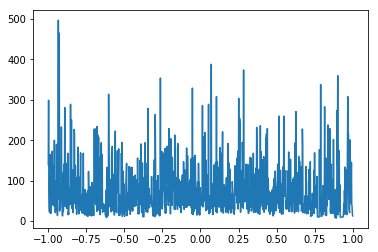

In [2]:
import matplotlib.pyplot as plt
plt.plot(X, num_collisions)
plt.show()

In [3]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

h = hole_range
x = x_range
y = y_range
side_bdy = np.array([(h,-y), (x,-y), (x,y), (-x,y), (-x,-y), (-h,-y)])
thetas = np.linspace(0, 2*np.pi, 100)
scatter_bdy = scatter_range * np.array([np.cos(thetas), np.sin(thetas)]).T

dpos = np.diff(pos_hist,axis=0)
def draw(steps=1):
    fig, ax = plt.subplots(figsize=[5,5])
    ax.plot(side_bdy[:,0], side_bdy[:,1])
    ax.fill(scatter_bdy[:,0], scatter_bdy[:,1])
    ax.quiver(pos_hist[:steps,0], pos_hist[:steps,1], dpos[:steps,0], dpos[:steps,1], angles='xy', scale_units='xy', scale=1)
    ax.set_aspect('equal')
    plt.show()
    
widgets.interact(draw,steps=(1,pos_hist.shape[0]-1));

NameError: name 'pos_hist' is not defined